___
## Ciência dos Dados - PROJETO 3 - INSPER

___
### Integrantes: 

#### Theo Barbara, Abel Cavalcante, Gustavo Pierre e Victor Jurdi
___

# Wines Review

___

## A. INTRODUÇÃO

Para o Projeto 3 de Ciências dos Dados, o grupo escolheu trabalhar com vinhos. O nosso DataSet contém 10 variavéis(Pais de origem,descrição do vinho,designação, pontos na avaliação, preço, provincia, região, variedade e a adega produtora. Com isso nosso grupo procura prever o preço do vinho através das variavéis mais qualificadas, que serão, o país, os pontos (nota do vinho) e o tipo da uva.

___
## B. MINERANDO DADOS e CARACTERÍSTICAS DO DATASET

[Detalhe aqui as características da base de dados além da análise descritiva.]

In [1]:
import pandas as pd
import os
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as DC
#from operator import itemgetter

In [2]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\Lenovo\OneDrive\Desktop\Insper\3° Semestre\CData - DP\projeto_Cdata\Projeto 3 - Previsão de preço de Vinhos


### BASE DE DADOS

In [3]:
x = pd.read_csv('winemag-data_first150k.csv')
del x["Unnamed: 0"]
x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude


In [4]:
dic = {}
dic2 = {}
lista = []
lista2=[]
i=0

for e in x.variety:
    if e not in dic:
        dic[e] = 1
    elif e in dic:
        dic[e] +=1

for e in dic:
    if dic[e] > 0:
        lista.append(dic[e]/len(dic))
        
for e in x.variety:
    if e not in dic2:
        dic2[e] = 1
        
for e in dic2:
    dic2[e] = lista[i]
    i+=1
    
for uva in x.variety:
    lista2.append(dic2[uva])
    
x['Frequencia'] = lista2

x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,0.349684
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,0.039557


In [5]:
# Separação do Dataframe em relação ao Preço

x.loc[(x.price<50),'Preço'] = 'Até 50'
x.loc[(x.price>50)&(x.price<=200),'Preço'] = 'Até 200'
x.loc[(x.price>200)&(x.price<=400),'Preço'] = 'Até 400'
x.loc[(x.price>400)&(x.price<=600),'Preço'] = 'Até 600'
x.loc[(x.price>600)&(x.price<=800),'Preço'] = 'Até 800'
x.loc[(x.price>800)&(x.price<=1000),'Preço'] = 'Até 1000'
x.loc[(x.price>1000)&(x.price<=1500),'Preço'] = 'Até 1500'
x.loc[(x.price>1500),'Preço'] = 'Mais que 1500'

In [6]:
# Separação do Dataframe em relação a pontução do vinho

x.loc[(x.points<=80),'Pontos'] = '80 pontos'
x.loc[(x.points>80)&(x.points<=85),'Pontos'] = '81 - 85 pontos'
x.loc[(x.points>85)&(x.points<=90),'Pontos'] = '86 - 90 pontos'
x.loc[(x.points>90)&(x.points<=95),'Pontos'] = '91 - 95 pontos'
x.loc[(x.points>95)&(x.points<=100),'Pontos'] = '95 - 100 pontos'

In [7]:
x.head()

,country,description,designation,points,price,province,region_1,region_2,variety,winery,Frequencia,Preço,Pontos
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz,20.253165,Até 400,95 - 100 pontos
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez,0.349684,Até 200,95 - 100 pontos
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley,10.000000,Até 200,95 - 100 pontos
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi,22.612342,Até 200,95 - 100 pontos
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude,0.039557,Até 200,91 - 95 pontos


### ANÁLISE DESCRITIVA

In [8]:
novo_x = x[x.Frequencia>0.5]

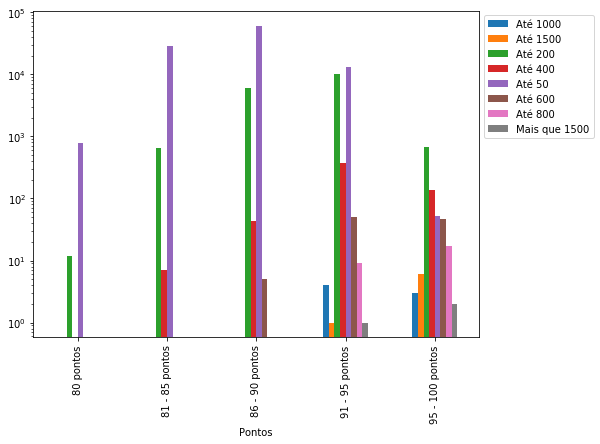

In [9]:
ct = pd.crosstab(novo_x.Pontos, novo_x.Preço)
ct.plot(kind='bar', figsize=(8, 6))
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8));

In [10]:
novo_x.points.corr(novo_x.price)

0.4600421512441059

In [11]:
novo_x.Frequencia.corr(novo_x.price)

0.11149984361374775

In [12]:
novo_x.Frequencia.corr(novo_x.points)

0.06969229048694064

In [13]:
#plt.hist(x.country);

In [14]:
# plt.hist(x["Preço"]);

In [15]:
# plt.hist(x.Pontos);

___
## C. MODELOS DE PREDIÇÃO

o MODELO DE PREDIÇÃO PELA MÉDIA (Sem uso de variável explicativa).

In [16]:
media_price = np.mean(x.price)
print('A média do preço é de R${0}'.format(media_price))

media_points = np.mean(x.points)
print('A média dos pontos é de {0}'.format(media_points))

A média do preço é de R$33.13148249353299
A média dos pontos é de 87.8884184721394


o MODELO DOS K VIZINHOS MAIS PRÓXIMOS (K-Nearest Neighbors Regression)

o MODELO DE REGRESSÃO LINEAR (Multiple Linear Regression)

o MODELO DE ÁRVORES DE REGRESSÃO (Decision Tree Regression)

___
## D. PROCESSO E ESTATÍSTICAS DE VALIDAÇÃO

[Esse item depende dos resultados das modelagens anteriores! Organize-os aqui de forma clara!]

___
## E. CONCLUSÃO

___
## F. REFERÊNCIAS BIBLIOGRÁFICAS